In [11]:
# 1. 라이브러리 설치 (없으면 실행)
!pip install -q sentence-transformers

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import os

# 설정
DATA_FILE = 'arxiv_cs_recent_filtered.csv' # 아까 만든 5만개 데이터 그대로 사용
EMBEDDING_FILE = 'sbert_embeddings_sampled_all-MiniLM-L6-v2.npy' # 파일명 변경

def get_embeddings_sbert():
    if not os.path.exists(DATA_FILE):
        print("❌ CSV 파일이 없습니다.")
        return

    # 1. 데이터 로드
    print("📂 CSV 로드 중...")
    df = pd.read_csv(DATA_FILE)
    
    # 제목과 초록을 합쳐서 넣으면 정확도가 더 올라갑니다.
    # 예: "Title: [제목] \n Abstract: [초록]" 형태
    texts = (
        "Title: " + df['title'].fillna("") + 
        " \n Abstract: " + df['abstract'].fillna("")
    ).tolist()
    
    print(f"총 논문 수: {len(texts)}")

    # 2. 모델 로드 (SBERT)
    # 'all-MiniLM-L6-v2': 가볍고 성능 좋은 국밥 모델
    # 'allenai-specter': 논문 전용 모델 (하지만 좀 느릴 수 있음) -> 일단 국밥 모델로 갑니다.
    print("⚡ 모델 로딩 중 (all-MiniLM-L6-v2)...")
    model = SentenceTransformer('all-MiniLM-L6-v2') 
    
    # GPU 사용 설정
    if torch.cuda.is_available():
        model = model.to('cuda')
    
    # 3. 임베딩 추출 (SBERT는 내부적으로 배치 처리/정규화를 알아서 다 해줍니다)
    print("🧠 임베딩 추출 시작...")
    embeddings = model.encode(
        texts, 
        batch_size=128, 
        show_progress_bar=True, 
        convert_to_numpy=True,
        normalize_embeddings=True # 코사인 유사도 위해 정규화 필수
    )

    # 4. 저장
    np.save(EMBEDDING_FILE, embeddings)
    print(f"\n✅ SBERT 임베딩 저장 완료! Shape: {embeddings.shape}")
    print(f"파일 위치: {EMBEDDING_FILE}")

if __name__ == "__main__":
    import torch # cuda 체크용
    get_embeddings_sbert()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


📂 CSV 로드 중...


/tmp/ipykernel_23903/1332772091.py:20: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


총 논문 수: 431657
⚡ 모델 로딩 중 (all-MiniLM-L6-v2)...
🧠 임베딩 추출 시작...


Batches:   0%|          | 0/3373 [00:00<?, ?it/s]


✅ SBERT 임베딩 저장 완료! Shape: (431657, 384)
파일 위치: sbert_embeddings_sampled_all-MiniLM-L6-v2.npy


In [9]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# 파일명 주의! (위에서 만든 파일명과 같아야 함)
DATA_FILE = 'arxiv_cs_recent_filtered.csv'
EMBEDDING_FILE = 'sbert_embeddings_sampled_all-MiniLM-L6-v2.npy' 

print("📂 데이터 로딩 중...")
df = pd.read_csv(DATA_FILE)
embeddings = np.load(EMBEDDING_FILE)
print("✅ 데이터 로드 완료")

# 모델 로드 (검색용)
model = SentenceTransformer('all-MiniLM-L6-v2')
if torch.cuda.is_available():
    model = model.to('cuda')

def search_similar_papers(query_text, top_k=5):
    # Query 인코딩
    query_vec = model.encode([query_text], convert_to_numpy=True, normalize_embeddings=True)
    
    # 유사도 계산 (Dot Product)
    scores = np.dot(query_vec, embeddings.T).flatten()
    
    # 상위 K개 추출
    top_indices = np.argsort(scores)[::-1][:top_k]
    
    print(f"\n🔍 Query: {query_text[:100]}...")
    print("-" * 80)
    
    for rank, idx in enumerate(top_indices):
        paper = df.iloc[idx]
        score = scores[idx]
        # 결과 출력
        print(f"[{rank+1}] 유사도: {score:.4f} | {paper['year']} | {paper['categories']}")
        print(f"Title: {paper['title']}")
        print(f"Link: https://arxiv.org/abs/{paper['id']}")
        print("-" * 80)

# --- 테스트 ---
my_abstract = """
We propose a novel method for split federated learning to address data heterogeneity.
Our approach uses gradient shuffling to improve convergence speed on non-IID data.
"""
search_similar_papers(my_abstract)

📂 데이터 로딩 중...


/tmp/ipykernel_23903/826977856.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


✅ 데이터 로드 완료

🔍 Query: 
We propose a novel method for split federated learning to address data heterogeneity.
Our approach ...
--------------------------------------------------------------------------------
[1] 유사도: 0.7858 | 2023 | cs.LG
Title: Convergence Analysis of Sequential Split Learning on Heterogeneous Data
Link: https://arxiv.org/abs/2302.01633
--------------------------------------------------------------------------------
[2] 유사도: 0.7830 | 2024 | cs.LG cs.CV cs.DC
Title: Synthetic data shuffling accelerates the convergence of federated   learning under data heterogeneity
Link: https://arxiv.org/abs/2306.13263
--------------------------------------------------------------------------------
[3] 유사도: 0.7471 | 2022 | cs.LG
Title: Toward Data Heterogeneity of Federated Learning
Link: https://arxiv.org/abs/2212.08944
--------------------------------------------------------------------------------
[4] 유사도: 0.7443 | 2021 | cs.LG
Title: Non-IID data and Continual Learning processes i

Matplotlib is building the font cache; this may take a moment.


🎨 UMAP으로 차원 축소 중 (약 1~2분 소요)...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


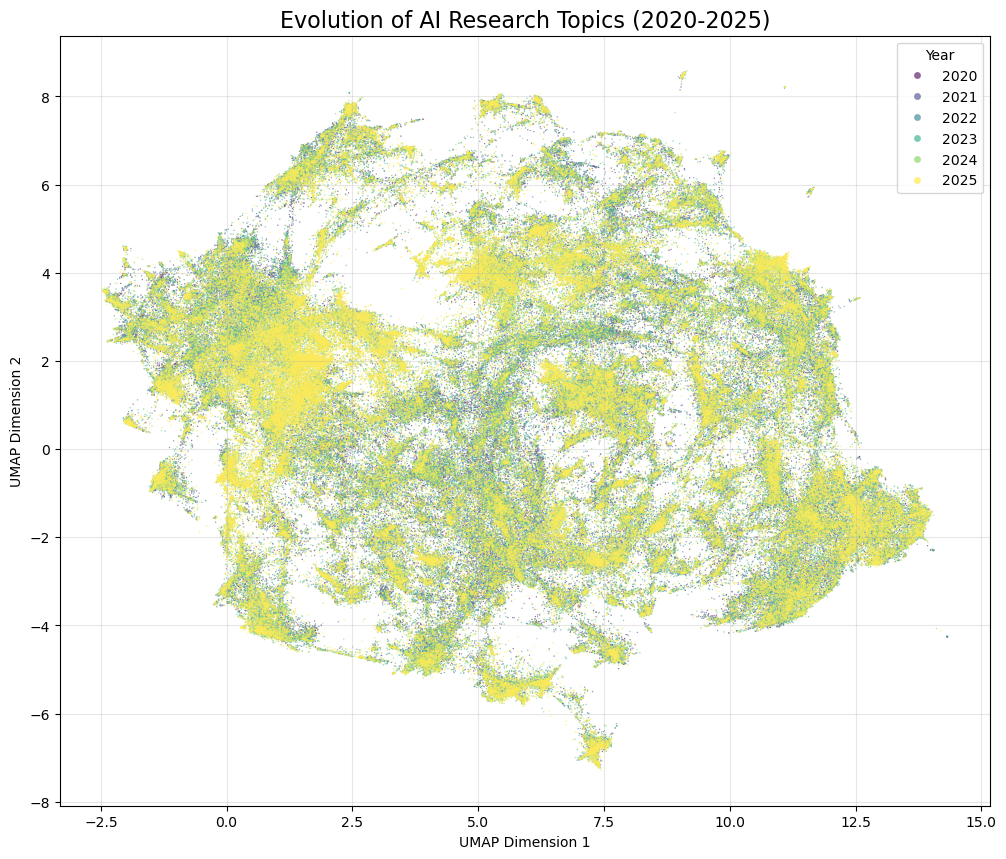

✅ 시각화 완료! 'trend_analysis.png' 파일이 생성되었습니다.


In [10]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# 1. UMAP 차원 축소 (768 -> 2)
print("🎨 UMAP으로 차원 축소 중 (약 1~2분 소요)...")
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# 데이터프레임에 좌표 추가
df['x'] = embedding_2d[:, 0]
df['y'] = embedding_2d[:, 1]

# 2. 시각화 (연도별 트렌드)
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    data=df, 
    x='x', y='y', 
    hue='year', 
    palette='viridis', # 색상 테마 (2020:보라 -> 2025:노랑)
    s=1, # 점 크기 (작게 해야 뭉침이 잘 보임)
    alpha=0.6,
    legend='full'
)

plt.title('Evolution of AI Research Topics (2020-2025)', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Year', loc='upper right', markerscale=5)
plt.grid(True, alpha=0.3)

# 이미지 저장 및 출력
plt.savefig('trend_analysis.png', dpi=300)
plt.show()

print("✅ 시각화 완료! 'trend_analysis.png' 파일이 생성되었습니다.")

In [14]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 설정
DATA_FILE = 'arxiv_cs_recent_filtered.csv'

def extract_yearly_keywords():
    print("📂 데이터 로드 및 키워드 분석 중...")
    df = pd.read_csv(DATA_FILE)
    
    # 불용어(의미 없는 단어) 추가 제거
    custom_stopwords = list(ENGLISH_STOP_WORDS) + [
        'propose', 'method', 'paper', 'based', 'approach', 'results', 'model', 
        'performance', 'state', 'art', 'using', 'novel', 'learning', 'network',
        'algorithm', 'models', 'proposed', 'data', 'experiments', 'show', 'task'
    ]
    
    years = sorted(df['year'].unique())
    
    print("\n" + "="*80)
    print(f"{'Year':<6} | {'Top Trending Keywords (Hot Topics)':<60}")
    print("="*80)
    
    for year in years:
        # 해당 연도의 모든 논문 제목 합치기 (초록보다 제목이 트렌드 더 잘 보여줌)
        year_docs = df[df['year'] == year]['title']
        combined_text = " ".join(year_docs.fillna(""))
        
        # 빈도 분석 (상위 10개)
        vectorizer = CountVectorizer(stop_words=custom_stopwords, max_features=1000, ngram_range=(1, 2))
        X = vectorizer.fit_transform([combined_text])
        feature_names = vectorizer.get_feature_names_out()
        
        # 빈도순 정렬
        row = X[0].toarray().flatten()
        top_indices = row.argsort()[::-1][:30] # 상위 8개
        top_keywords = [feature_names[idx] for idx in top_indices]
        
        print(f"{year:<6} | {', '.join(top_keywords)}")
    print("="*80)

if __name__ == "__main__":
    extract_yearly_keywords()

📂 데이터 로드 및 키워드 분석 중...


/tmp/ipykernel_23903/1327813045.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)



Year   | Top Trending Keywords (Hot Topics)                          
2020   | deep, neural, networks, multi, detection, image, neural networks, classification, machine, graph, adversarial, segmentation, recognition, reinforcement, analysis, language, supervised, object, prediction, convolutional, time, estimation, 3d, efficient, training, optimization, domain, images, generation, self
2021   | neural, deep, networks, multi, detection, image, neural networks, graph, classification, machine, segmentation, reinforcement, adversarial, recognition, supervised, prediction, language, analysis, efficient, time, training, self, object, domain, 3d, estimation, attention, framework, aware, optimization
2022   | neural, deep, multi, detection, networks, image, graph, language, neural networks, classification, segmentation, machine, supervised, reinforcement, recognition, efficient, self, training, analysis, object, prediction, time, domain, 3d, estimation, adversarial, framework, text, generatio

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# 설정 (아까 만든 샘플 파일을 쓰는게 속도가 빠릅니다. 원본이 있다면 원본명 쓰셔도 됩니다)
DATA_FILE = 'arxiv_cs_recent_filtered.csv' 
# DATA_FILE = 'arxiv_cs_recent_filtered.csv' 

def extract_distinctive_keywords():
    print(f"📂 데이터 로드 중... ({DATA_FILE})")
    try:
        df = pd.read_csv(DATA_FILE)
    except FileNotFoundError:
        print("❌ 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        return

    # 불용어(의미 없는 단어) 추가 제거
    custom_stopwords = list(ENGLISH_STOP_WORDS) + [
        'propose', 'method', 'paper', 'based', 'approach', 'results', 'model', 
        'performance', 'state', 'art', 'using', 'novel', 'learning', 'network',
        'algorithm', 'models', 'proposed', 'data', 'experiments', 'show', 'task',
        'neural', 'networks', 'deep', 'analysis', 'applications', 'study', 'use'
    ]
    
    years = sorted(df['year'].unique())
    keywords_by_year = {} # 연도별 키워드 저장소
    
    print("📊 연도별 키워드 분석 및 공통 단어 필터링 중...")
    
    # 1. 각 연도별 Top 20 추출하여 저장
    for year in years:
        year_docs = df[df['year'] == year]['title']
        combined_text = " ".join(year_docs.fillna(""))
        
        # 빈도 분석
        vectorizer = CountVectorizer(stop_words=custom_stopwords, max_features=1000, ngram_range=(1, 2))
        try:
            X = vectorizer.fit_transform([combined_text])
            feature_names = vectorizer.get_feature_names_out()
            
            # 빈도순 정렬 및 Top 20 추출
            row = X[0].toarray().flatten()
            top_indices = row.argsort()[::-1][:50] 
            top_keywords = [feature_names[idx] for idx in top_indices]
            
            keywords_by_year[year] = top_keywords
        except ValueError:
            # 데이터가 너무 적어서 어휘가 생성 안 된 경우
            keywords_by_year[year] = []

    # 2. 모든 연도에 공통적으로 등장한 키워드(교집합) 찾기
    if keywords_by_year:
        # 첫 번째 해의 키워드를 기준으로 시작해서 계속 교집합(intersection)을 구함
        common_keywords = set(keywords_by_year[years[0]])
        for year in years[1:]:
            common_keywords = common_keywords.intersection(set(keywords_by_year[year]))
            
        print("\n" + "="*80)
        print(f"🚫 제외된 공통 키워드 (모든 연도 등장): {', '.join(common_keywords)}")
        print("="*80 + "\n")

        # 3. 공통 키워드 제거 후 출력
        print(f"{'Year':<6} | {'Distinctive Trending Keywords (Unique per Year)':<60}")
        print("-" * 80)
        
        for year in years:
            # 원래 리스트 순서(빈도순)를 유지하면서 공통 키워드만 제거
            unique_list = [k for k in keywords_by_year[year] if k not in common_keywords]
            
            # 너무 많이 빠져서 리스트가 짧아질 수 있으므로 상위 10~15개 정도만 문자열로 변환
            unique_str = ', '.join(unique_list[:15]) 
            print(f"{year:<6} | {unique_str}")
            
        print("="*80)

if __name__ == "__main__":
    extract_distinctive_keywords()

📂 데이터 로드 중... (arxiv_cs_recent_filtered.csv)


/tmp/ipykernel_23903/3870674467.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


📊 연도별 키워드 분석 및 공통 단어 필터링 중...

🚫 제외된 공통 키워드 (모든 연도 등장): dynamic, adaptive, control, knowledge, robust, classification, training, prediction, attention, human, self, detection, segmentation, graph, image, video, language, machine, object, optimization, multi, systems, time, framework, reinforcement, 3d, efficient, aware, visual, generation, text

Year   | Distinctive Trending Keywords (Unique per Year)             
--------------------------------------------------------------------------------
2020   | adversarial, recognition, supervised, convolutional, estimation, domain, images, end, unsupervised, semantic, feature, generative, speech, representation, scale
2021   | adversarial, recognition, supervised, domain, estimation, semantic, convolutional, unsupervised, representation, end, images, feature, shot, speech, generative
2022   | supervised, recognition, domain, estimation, adversarial, transformer, representation, semantic, images, shot, speech, federated, feature, end, cross
202